In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=cuda"

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from results_summary import load_all_models

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:84:00.0)


In [2]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

In [3]:
dl_args = dict(npoint=300, nlayer=3, nneuron=30, init_log_lam=-3, points_std=0.0, keep_prob=1.0, init_weight_std=1.0, noise_std=0.05,
                    points_type="opt", log_lam_weights=-6, step_size=1e-2, mixture_kernel=False, init_log_sigma=np.linspace(0,1,3), base=True,
                    niter=10000, ntrain=100, nvalid=100, patience=200, gpu_count=0, clip_score=False, curve_penalty=1, train_stage=2)

others_args = dict( n_hiddens = [100]*2,
                    n_comps = 10,
                    n_layers = 5,
                    act_fun = 'tanh',
                    mode = 'random')

* `p` is the data object
* `m` is a dict of all models
* `l` is a dict of log liks
* `s` is a dict of samples (not for dkef)

In [4]:
from kgof import density, data, kernel
from kmod import mctest
from itertools import combinations

def run_all_steins(data_name, seeds=range(15), save=True):
    model_names = None
    ps = None
    stats = None
    k = kernel.KPoly(degree=3)

    for seed_i, seed in enumerate(tqdm(seeds, unit="seed")):
        p, m, l, s = load_all_models(data_name, seed, dl_args, others_args)
        print m
        if model_names is None:
            model_names = sorted(m)
            n = len(model_names)

            ps = np.full((len(seeds), n, n), np.nan)
            stats = np.full_like(ps, np.nan)
        else:
            assert model_names == sorted(m)

        test_data = data.Data(p.test_data)

        rs = np.random.RandomState(seed=seed_i)
        V = p.test_data[rs.choice(p.test_data.shape[0], 100)]
        V += rs.normal(scale=.2, size=V.shape)

        densities = {name: density.from_grad_log(p.D, model.grad)
                     for name, model in m.iteritems()}

        #for i, j in tqdm(list(combinations(range(n), 2)), unit="test"):
        i = 0
        for j in tqdm(range(n), unit="test"):
            d1 = densities[model_names[i]]
            d2 = densities[model_names[j]]
            res = mctest.DC_FSSD(d1, d2, k, k, V, V).perform_test(test_data)
            ps[seed_i, i, j] = res['pvalue']
            ps[seed_i, j, i] = 1 - res['pvalue']
            stats[seed_i, i, j] = res['test_stat']
            stats[seed_i, j, i] = -res['test_stat']

    if save:
        np.savez('stein_{}.npz'.format(data_name), ps=ps, stats=stats, model_names=model_names)
    return ps, stats, model_names

In [5]:
dnames = ["redwine", "whitewine", "parkinsons", "miniboone", "hepmass"]
dnames = ["hepmass"]


for dname in dnames:
    run_all_steins(dname)

  0%|          | 0/15 [00:00<?, ?seed/s]

INFO:tensorflow:Restoring parameters from ckpts/H_D22_l3_nd30_np300_nt100_nv100_pto_ss100_ni10000_n05_k10_m0_b1_p200_nk3_cl0_cu1_s00.ckpt


INFO: 2018-10-03 12:04:40,954: tf_logging.info(): Restoring parameters from ckpts/H_D22_l3_nd30_np300_nt100_nv100_pto_ss100_ni10000_n05_k10_m0_b1_p200_nk3_cl0_cu1_s00.ckpt


IOError: [Errno 2] No such file or directory: 'maf_models/hepmass/hepmass_maf_rnd_100_100_layers_5_tanh_p200_s00.pkl'

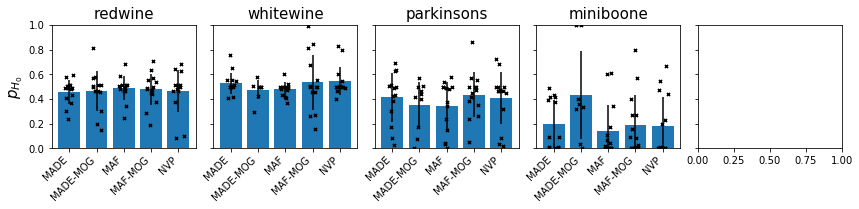

In [9]:
fig, axes = plt.subplots(1,5, figsize=(12,3), sharex=False, sharey=True)

display_names = dict(dkef="DKEF", made="MADE", maf="MAF", made_mog = "MADE-MOG", maf_mog="MAF-MOG", nvp="NVP")

dnames = ["redwine", "whitewine", "parkinsons", "miniboone"]

for di, dname in enumerate(dnames):

    test_res = np.load("stein_%s.npz" % dname.lower())
    
    ps = test_res["ps"]
    stats = test_res["stats"]
    model_names = test_res["model_names"]

    pvalues = ps[:, 1:, 0]
    ax = axes[di]


    ax.set_title(dname, fontsize=15)
    ax.bar(np.arange(5), np.nanmean(pvalues,0), yerr=np.nanstd(pvalues,0))
    
    x = np.repeat(np.arange(5)[None,:],[ps.shape[0]], axis=0).flatten()
    x = x + np.random.uniform(-0.2,0.2,*x.shape)
    ax.scatter(x, pvalues.flatten(), 10, 'k', marker="x", zorder=3)
    
       
    ax.set_xticks(range(5))
    ax.set_xticklabels([display_names[k] for k in model_names[1:]], rotation=45, ha="right", position=(0.0,0.01))
    ax.set_ylim([0,1])
    
    if di == 0:
        ax.set_ylabel(r"$p_{H_0}$", fontsize=15)
fig.tight_layout(w_pad=0)
#fig.savefig("figs/real_data_stein.pdf")